In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200
from scipy import stats, integrate, optimize, interpolate, linalg
import numba

In [2]:
import sim_steady_state as sim
from sim_fake_news import jacobian

Set up same general equilibrium steady state as previous notebooks, and calculate "M", "Mr", and "A" matrices as in the lecture 8 figures:

In [3]:
ss = sim.example_calibration()

B = 4*0.35
tau = ss['r']*B
e = ss['y']

beta_ge = optimize.brentq(lambda beta: sim.steady_state(ss['Pi'], ss['a_grid'],
                                    (1-tau)*e, ss['r'], beta, ss['eis'])['A'] - B, 0.96, 0.995)
ss = sim.steady_state(ss['Pi'], ss['a_grid'], (1-tau)*e, ss['r'], beta_ge, ss['eis'])
ss['A'] - B # check asset market clearing

-1.4503953593703045e-12

In [4]:
T = 500
J = jacobian(ss, {'Y': {'y': e}, 'r': {'r': 1}}, T+1)
M_HA, A_HA = J['C']['Y'][:T, :T], J['A']['Y'][:T, :T]
Mr_HA, Ar_HA = J['C']['r'][:T, 1:], J['A']['r'][:T, 1:]

## Computing behavioral Jacobian
Implementing the formula
$$\widetilde{J}_{t,s}=\sum_{\tau=0}^{\text{min}(t,s)}(E_{\tau,s}-E_{\tau-1,s})J_{t-\tau,s-\tau}$$

In [5]:
@numba.njit
def behavioral_J(J, E):
    T = len(J)
    Jnew = E[0, :] * J
    for t in range(T):
        for s in range(T):
            for tau in range(1, min(t, s)+1):
                Jnew[t, s] += (E[tau, s] - E[tau-1, s])*J[t-tau, s-tau]
    return Jnew

## Obtaining cognitive discounting and sticky expectations E matrices

In [6]:
def E_cogdisc(alpha, T):
    return np.maximum(linalg.toeplitz(alpha**np.arange(T)), np.tril(np.ones((T, T))))

In [7]:
E_cogdisc(0.5, 4)

array([[1.   , 0.5  , 0.25 , 0.125],
       [1.   , 1.   , 0.5  , 0.25 ],
       [1.   , 1.   , 1.   , 0.5  ],
       [1.   , 1.   , 1.   , 1.   ]])

In [8]:
def E_stickyexp(theta, T):
    E_stickyinfo = np.outer(1 - theta**(1+np.arange(T)), np.ones(T))
    return np.maximum(E_stickyinfo, np.tril(np.ones((T, T))))

In [9]:
E_stickyexp(0.5, 4)

array([[1.   , 0.5  , 0.5  , 0.5  ],
       [1.   , 1.   , 0.75 , 0.75 ],
       [1.   , 1.   , 1.   , 0.875],
       [1.   , 1.   , 1.   , 1.   ]])

## Modify with a fair amount of cognitive discounting ($\alpha=0.9$) and sticky expectations ($\theta=0.8$)

In [10]:
alpha = 0.9
E_cd = E_cogdisc(alpha, T)
M_HA_cd, A_HA_cd = behavioral_J(M_HA, E_cd), behavioral_J(A_HA, E_cd)
Mr_HA_cd, Ar_HA_cd = behavioral_J(Mr_HA, E_cd), behavioral_J(Ar_HA, E_cd)

In [11]:
theta = 0.8
E_se = E_stickyexp(theta, T)
M_HA_se, A_HA_se = behavioral_J(M_HA, E_se), behavioral_J(A_HA, E_se)
Mr_HA_se, Ar_HA_se = behavioral_J(Mr_HA, E_se), behavioral_J(Ar_HA, E_se)

## Fiscal policy exercise

We'll do a deficit-financed tax cut shock, where there is some shock to borrowing, and the government accumulates and repays debt following a fiscal rule like in lecture 9:

In [12]:
def fiscal_rule(borrowing_shock, rho):
    dB = borrowing_shock.copy()
    for t in range(1, T):
        dB[t] += rho*dB[t-1]

    # now calcluate implied dT
    dT = -dB.copy()
    dT[1:] += (1+ss['r'])*dB[:-1]
    return dB, dT

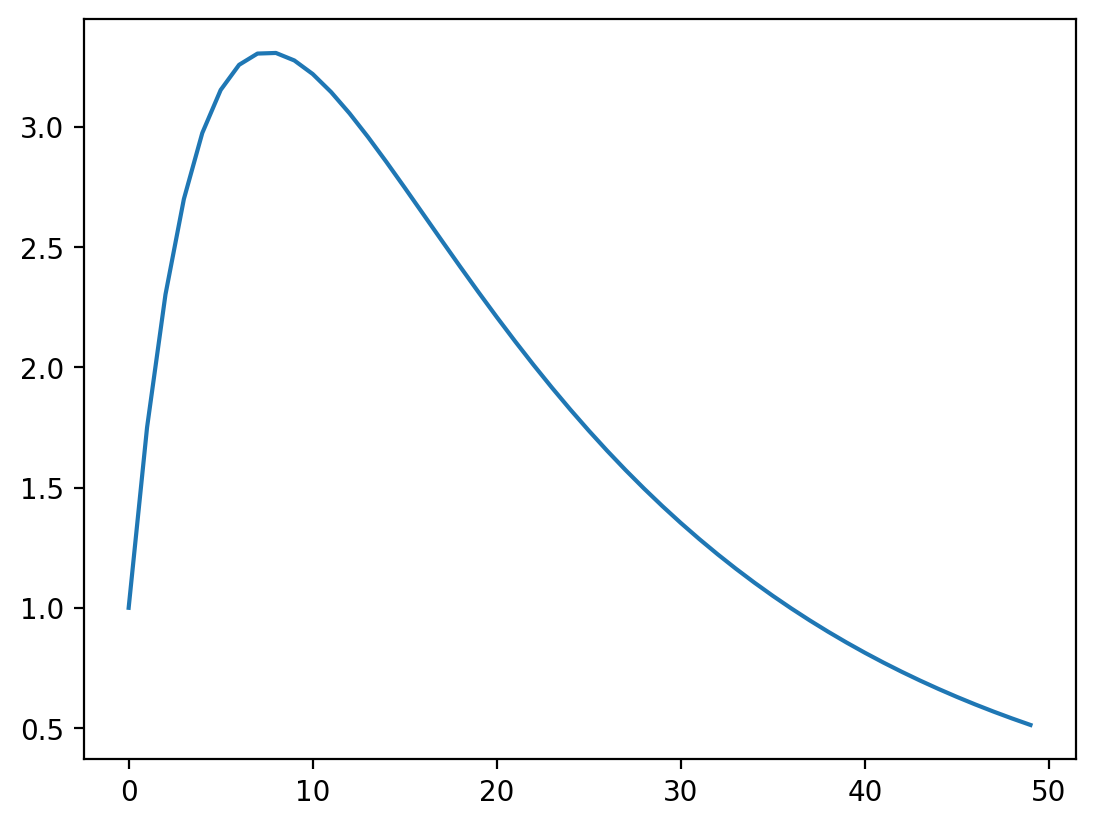

In [13]:
# original shock to borrowing
dB, dT = fiscal_rule(0.8**np.arange(T), 0.95)
plt.plot(dB[:50], label='dB')

For stability, we'll solve the asset market equation $\mathbf{A}(d\mathbf{Y} - d\mathbf{T}) = d\mathbf{B}$ as $d\mathbf{Y} = \mathbf{A}^{-1}d\mathbf{B} + d\mathbf{T}$:

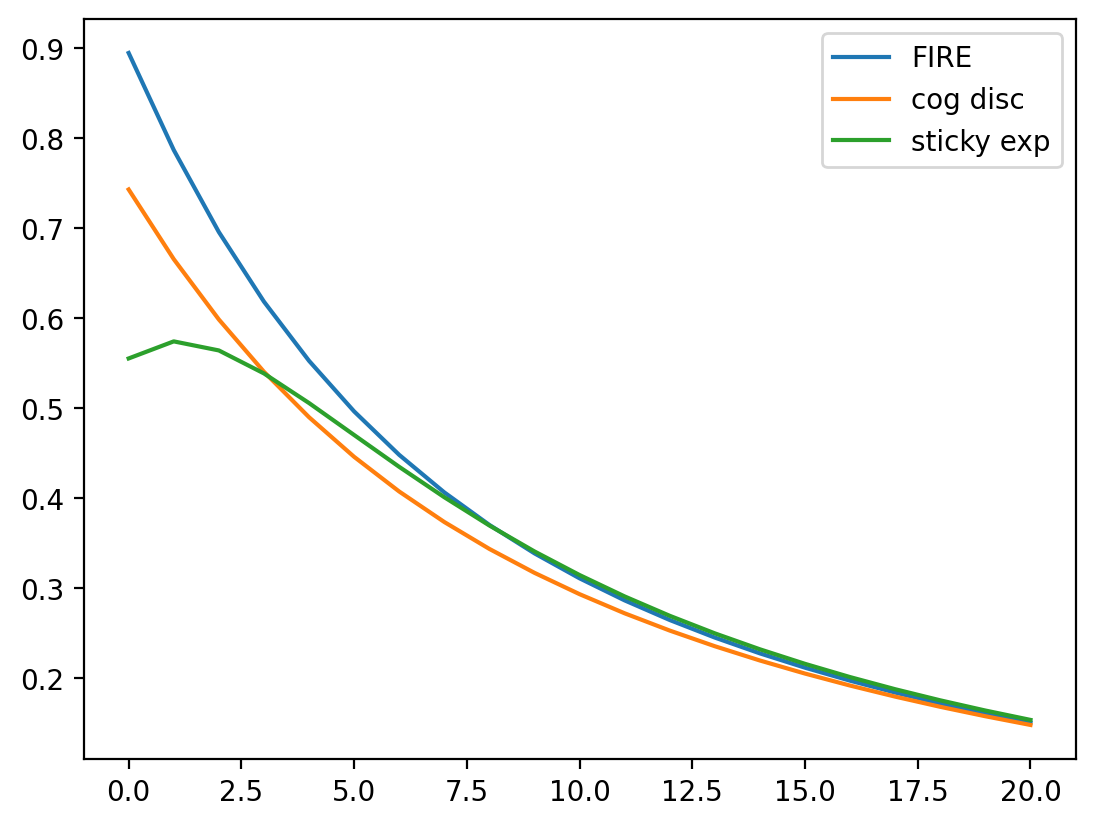

In [14]:
dY = np.linalg.solve(A_HA, dB) + dT
dY_cd = np.linalg.solve(A_HA_cd, dB) + dT
dY_se = np.linalg.solve(A_HA_se, dB) + dT

plt.plot(dY[:21], label='FIRE')
plt.plot(dY_cd[:21], label='cog disc')
plt.plot(dY_se[:21], label='sticky exp')
plt.legend();

We see that cognitive discounting and sticky expectations have smaller output effects, with the latter eventually converging to FIRE. This is because the income boost from output is not fully anticipated, so there is less anticipatory spending—and this outweighs the effects of failing to anticipate taxes, which go in the other direction overall.

Suppose that we only have imperfect anticipation of output, not taxes. Then we can write the asset equation as

$$\widetilde{\mathbf{A}}d\mathbf{Y} - \mathbf{A}d\mathbf{T} = d\mathbf{B}$$

and solve by writing

$$d\mathbf{Y} = \widetilde{\mathbf{A}}^{-1}d\mathbf{B} + \widetilde{\mathbf{A}}^{-1}\mathbf{A}d\mathbf{T}$$

What does this look like?

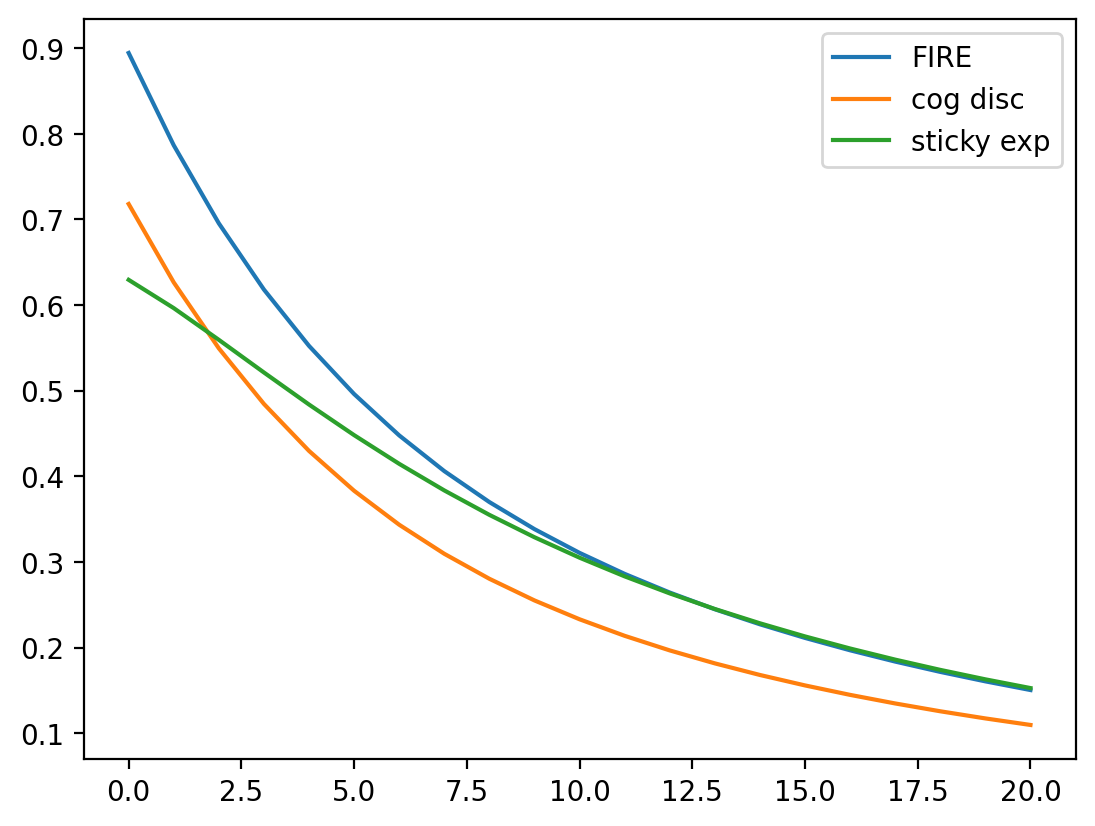

In [15]:
dY = np.linalg.solve(A_HA, dB) + dT
dY_cd = np.linalg.solve(A_HA_cd, dB) + np.linalg.solve(A_HA_cd, A_HA @ dT)
dY_se = np.linalg.solve(A_HA_se, dB) + np.linalg.solve(A_HA_se, A_HA @ dT)

plt.plot(dY[:21], label='FIRE')
plt.plot(dY_cd[:21], label='cog disc')
plt.plot(dY_se[:21], label='sticky exp')
plt.legend();

Now the gap is even larger, because the rational anticipation of taxes has a negative effect on spending.

Alternatively, we could do the same kind of exercise, but assuming that only taxes are imperfectly anticipated, rather than income. Now, everything reverses: there's a **larger** effect with impefect expectations, because people spend more knowing that less will be taxes:

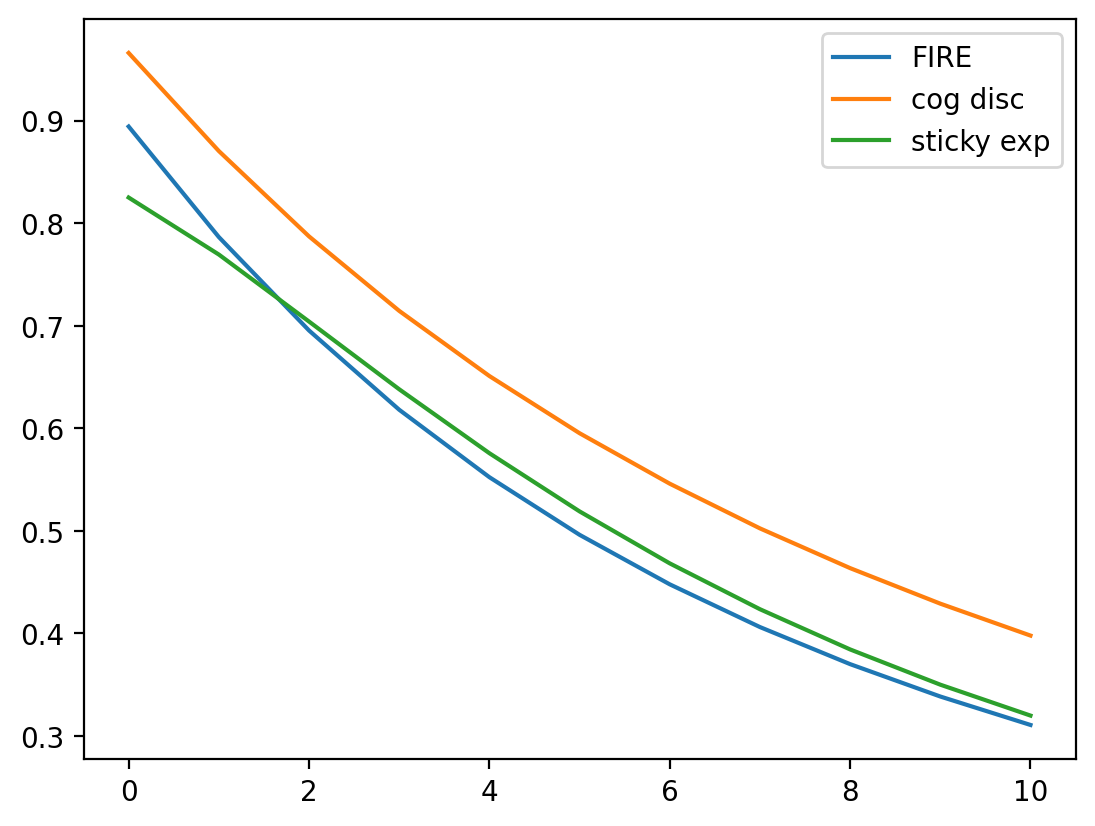

In [16]:
dY = np.linalg.solve(A_HA, dB) + dT
dY_cd = np.linalg.solve(A_HA, dB) + np.linalg.solve(A_HA, A_HA_cd @ dT)
dY_se = np.linalg.solve(A_HA, dB) + np.linalg.solve(A_HA, A_HA_se @ dT)

plt.plot(dY[:11], label='FIRE')
plt.plot(dY_cd[:11], label='cog disc')
plt.plot(dY_se[:11], label='sticky exp')
plt.legend();

## Monetary policy exercise
Let's assume a somewhat more persistent monetary policy shock than in lecture 9, with $r_t^{ante} = -0.9^t$, but otherwise specify the same default monetary policy as in lecture 8.

In [17]:
dr = -0.9**np.arange(T)
dT = dr*B/(1+ss['r'])
dB = -dT

We see that the response to the shock is weaker in both the cognitive discounting and sticky expectations cases, but only sticky expectations can generate the "hump":

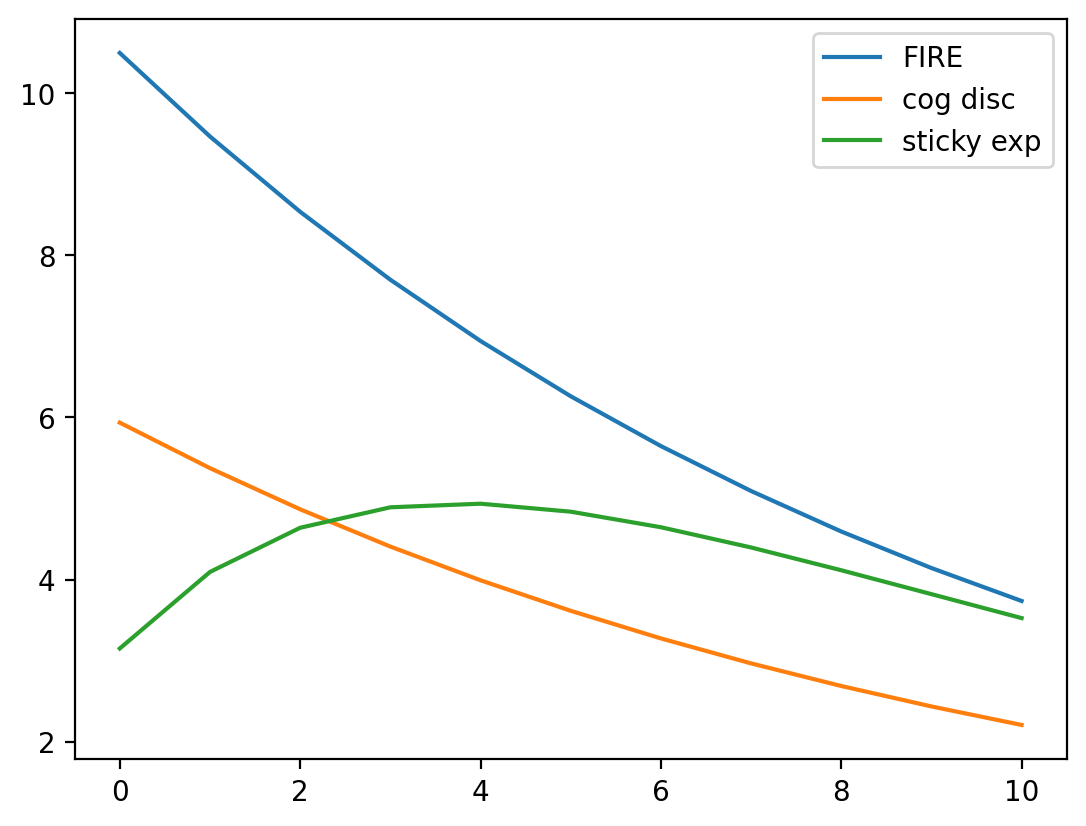

In [18]:
dY = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
dY_cd = np.linalg.solve(A_HA_cd, dB - Ar_HA_cd @ dr) + dT
dY_se = np.linalg.solve(A_HA_se, dB - Ar_HA_se @ dr) + dT

plt.plot(dY[:11], label='FIRE')
plt.plot(dY_cd[:11], label='cog disc')
plt.plot(dY_se[:11], label='sticky exp')
plt.legend();

We could also assume FIRE on interest rates, and only imperfect expectations on income. Then we still get some attenuation and a near-hump, but it's not as big a deal:

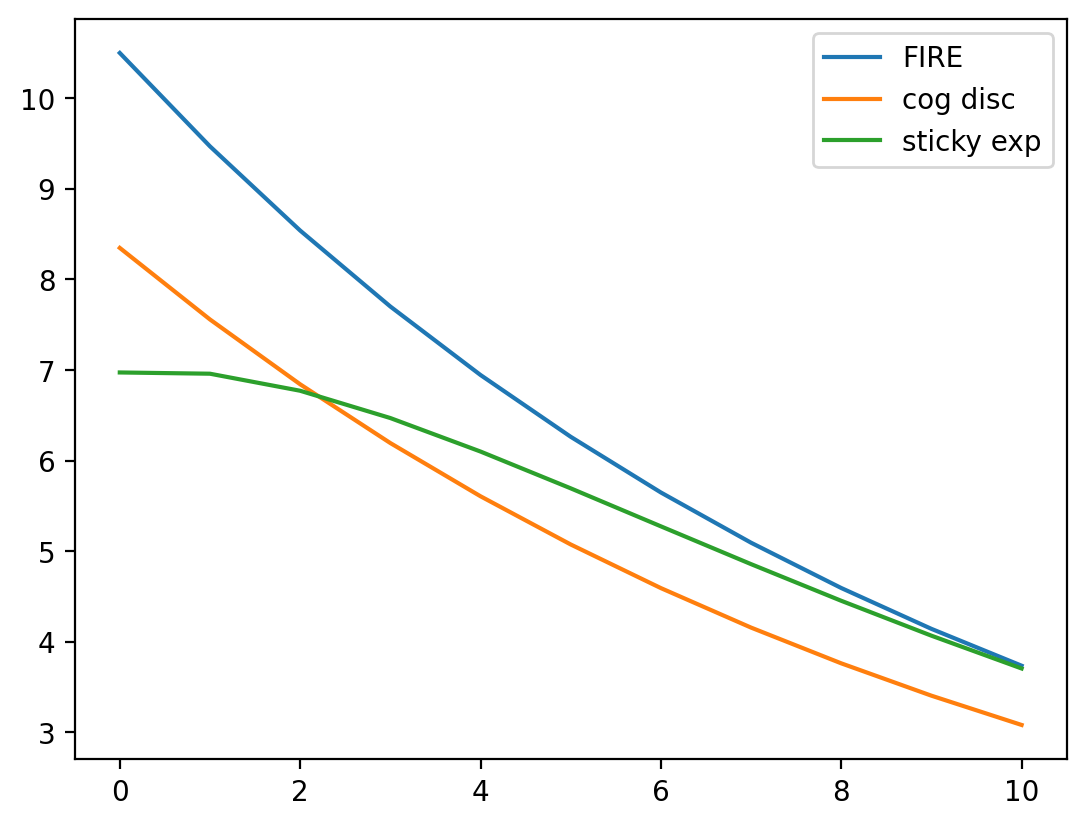

In [19]:
dY = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
dY_cd = np.linalg.solve(A_HA_cd, dB - Ar_HA @ dr) + dT
dY_se = np.linalg.solve(A_HA_se, dB - Ar_HA @ dr) + dT

plt.plot(dY[:11], label='FIRE')
plt.plot(dY_cd[:11], label='cog disc')
plt.plot(dY_se[:11], label='sticky exp')
plt.legend();

## Forward guidance shock
Let's assume a far-in-advance forward guidance shock, say at period 20 (5 years in the future, given that these are quarters), and go back to assuming imperfect information for all variables:

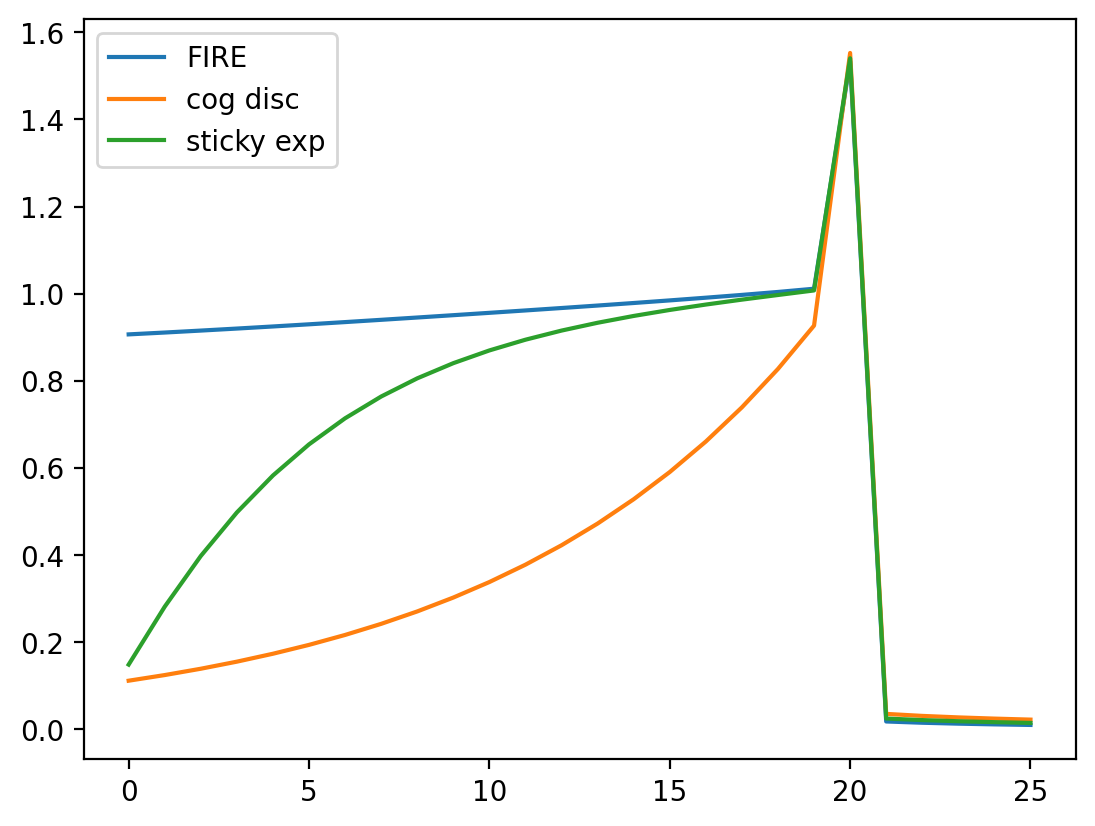

In [20]:
dr = -1.*(np.arange(T)==20)
dT = dr*B/(1+ss['r'])
dB = -dT

dY = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
dY_cd = np.linalg.solve(A_HA_cd, dB - Ar_HA_cd @ dr) + dT
dY_se = np.linalg.solve(A_HA_se, dB - Ar_HA_se @ dr) + dT

plt.plot(dY[:26], label='FIRE')
plt.plot(dY_cd[:26], label='cog disc')
plt.plot(dY_se[:26], label='sticky exp')
plt.legend();

This is perhaps our most interesting outcome. Forward guidance on real interest rates is highly effective with FIRE (not quite as much as the contemporaneous effect where there's the spike from the tax cut, but close), but the initial effect falls quite low under cognitive discounting and sticky expectations. With sticky expectations, however, there's near-convergence to FIRE after 10 quarters, since most people know about the shock. With cognitive discounting, we just get attenuation until the shock actually hits.

What if, for this shock, we assumed perfect information about interest rates but not output and transfers, like before? We still get a fairly big effect, because we're attenuating the large "indirect" effects, but not as large as before:

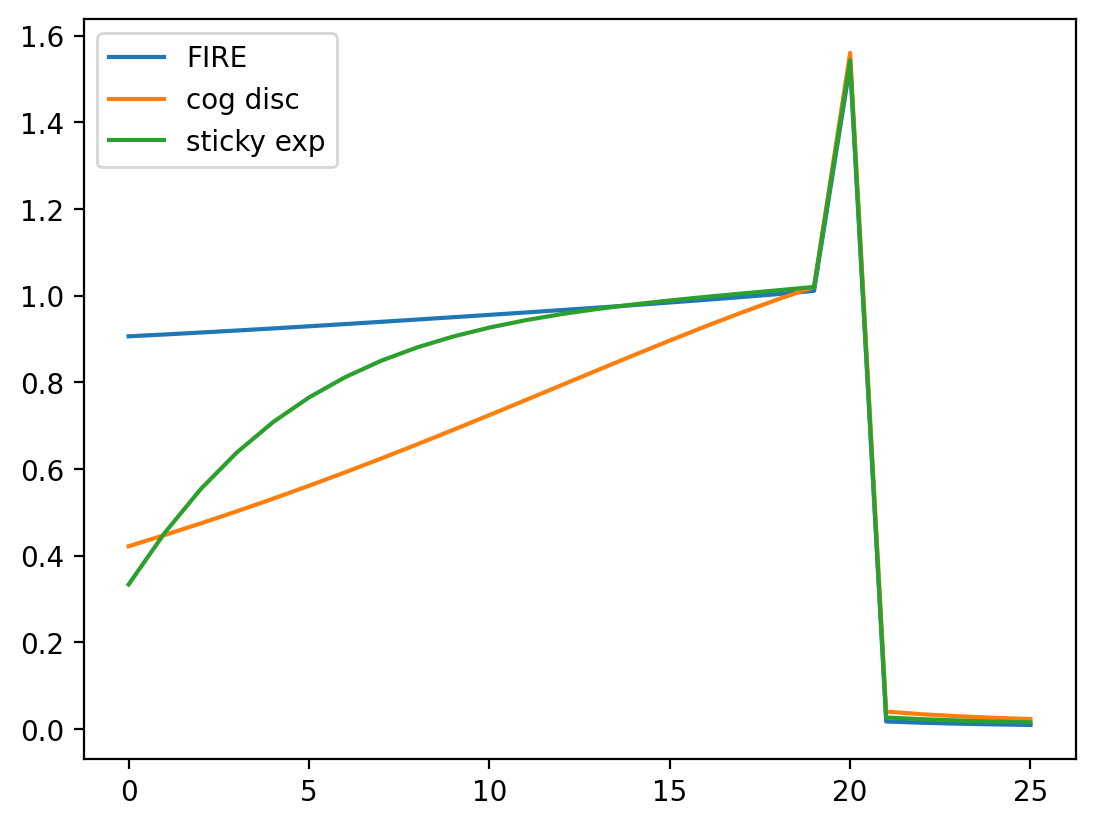

In [21]:
dY = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
dY_cd = np.linalg.solve(A_HA_cd, dB - Ar_HA @ dr) + dT
dY_se = np.linalg.solve(A_HA_se, dB - Ar_HA @ dr) + dT

plt.plot(dY[:26], label='FIRE')
plt.plot(dY_cd[:26], label='cog disc')
plt.plot(dY_se[:26], label='sticky exp')
plt.legend();